In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import features
import helpers
import plots

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
data_folder = 'data/csv/'
data_files = [mice + ".smo.csv" for mice in helpers.mice_breeds["c57bl6"]][:]
data_files_train = data_files[0:-1]
data_files_test = data_files[-1:]

print(f"Training on {data_files_train}")
print(f"Testing on {data_files_test}")

days = [0, 1, 2, 3]
window_sizes = [2, 5, 10]
window_features = ["EEGv", "EMGv"]
test_size = 0.3
useRaw = False
dropBins = False
cat_matrix = True # True for neural net, any for random forest
standardize_df = False
seed = 13

Training on ['BL601.smo.csv', 'BL602.smo.csv', 'BL606.smo.csv', 'BL609.smo.csv', 'BL610.smo.csv', 'BL611.smo.csv', 'BL612.smo.csv', 'BL614.smo.csv', 'BL616.smo.csv', 'BL6V1.smo.csv', 'BL6V2.smo.csv']
Testing on ['BL6V3.smo.csv']


In [3]:
# train and test on same mice
df_train = features.clean_data(data_folder, data_files_train, days, window_sizes, window_features, dropBins, useRaw, balance=True, standardize_df=standardize_df)
df_test = features.clean_data(data_folder, data_files_test, days, window_sizes, window_features, dropBins, useRaw, balance=False, standardize_df=standardize_df)

x_train, x_test, y_train, y_test, le = features.encode_scale_data(df_train, df_test, useRaw, seed, cat_matrix)

Removed 14 rows with invalid log values in BL606.smo.csv
Removed 186 rows with invalid log values in BL609.smo.csv
Removed 100 rows with invalid log values in BL610.smo.csv
Removed 3 rows with invalid log values in BL611.smo.csv
Removed 611 rows with invalid log values in BL612.smo.csv
Removed 9 rows with invalid log values in BL614.smo.csv
Removed 723 rows with invalid log values in BL616.smo.csv
Removed 1 rows with invalid log values in BL6V1.smo.csv
Removed 654 rows with invalid log values in BL6V2.smo.csv
Balancing classes to 47310 samples per class (total: 141930)
Removed 14 rows with invalid log values in BL6V3.smo.csv


# Neural Network

In [4]:
def baseline_model(input_dim, num_classes, lr=0.0001):
    model = Sequential()
    model.add(Dense(3, input_dim=input_dim, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

    return model

model = baseline_model(x_train.shape[1], le.classes_.size)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 1290      
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
Total params: 1,302
Trainable params: 1,302
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

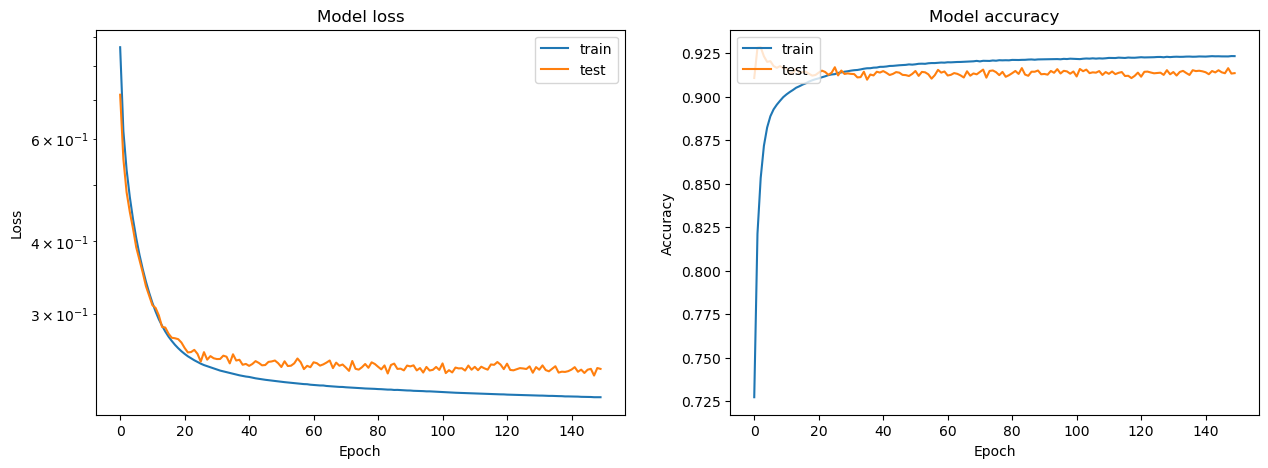

In [5]:
model = baseline_model(x_train.shape[1], le.classes_.size)
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=150,
                    batch_size=128,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

plots.plot_history(history.history)

2700/2700 [==============================] - 2s 587us/step
[[30859   921   199]
 [   99  4119    65]
 [ 1198  4994 43923]]
              precision    recall  f1-score   support

           n       0.96      0.96      0.96     31979
           r       0.41      0.96      0.58      4283
           w       0.99      0.88      0.93     50115

    accuracy                           0.91     86377
   macro avg       0.79      0.93      0.82     86377
weighted avg       0.95      0.91      0.93     86377



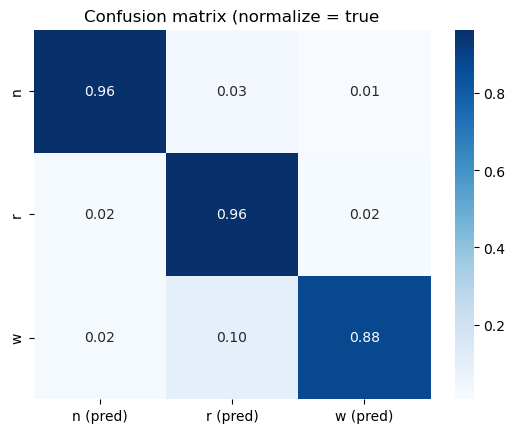

In [6]:
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

# K-Fold Cross Validation

In [7]:
#from sklearn.model_selection import KFold
#
#x, y, le = features.split_encode_scale_data_kfold(df, useRaw, seed, cat_matrix=True)
#model = baseline_model(x_train.shape[1], le.classes_.size)
#
#kfold = KFold(n_splits=5, shuffle=True)
#
## K-fold Cross Validation model evaluation
#fold_no = 1
#for train, test in kfold.split(x, y):
#  model = baseline_model(x_train.shape[1], le.classes_.size)
#  # Generate a print
#  print(f'Training for fold {fold_no} ...')
#
#  # Fit data to model
#  history = model.fit(x=x[train],
#                    y=y[train],
#                    epochs=300,
#                    batch_size=64,
#                    verbose=0,
#                )
#
#  # confusion matrix
#  cm = np.zeros((le.classes_.size, le.classes_.size))
#  cm = cm + plots.confusion(model=model, x_test=x[test], y_test=y[test], le=le, cat_matrix=True)
#  # Increase fold number
#  fold_no = fold_no + 1
#
#confusion = pd.DataFrame(cm, index=le.classes_, columns=le.classes_ + ' (pred)')
#sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
#plt.title(f'Confusion matrix (normalize = true')
#plt.show()

# Random Forest

In [8]:
#rfc = RandomForestClassifier(random_state=seed)
#rfc.fit(x_train, y_train)
#y_predict = rfc.predict(x_test)

#plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')